# Lab | Sequence Modeling with LSTM

In [2]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16 #sequence length
trunc_type='post' #in case sequence lenght is shorter in the beginning. padding is at the end.
padding_type='post'
oov_tok = "<OOV>" #out of vocabulary word
training_size= 16000 # Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1


2024-06-13 14:22:02.751340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# with open("./training.1600000.processed.noemoticon.csv", 'r', encoding='latin1') as csvfile:
    # reader = csv.reader(csvfile, delimiter=',', quotechar='"')

# with open("training.1600000.processed.noemoticon.csv") as csvfile:
#     reader = csv.reader(csvfile, delimiter=',')

# file_path = 'training.1600000.processed.noemoticon.csv'
# reader = pd.read_csv(file_path, encoding='latin-1', header=None)

file_path = "training.1600000.processed.noemoticon.csv"

corpus = []
num_sentences = 0

In [13]:


with open(file_path, encoding='utf-8', errors='replace') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if len(row) >= 6:
            list_item = []
            text = row[5]
            label = 0 if row[0] == '0' else 1
            list_item = [text, label]
        
            num_sentences = num_sentences + 1
            corpus.append(list_item)     
        else:
            print (f"Skipping row due to insufficient columns: {row}")   
        
        
        # text = row[5]  # Tweet text is in column 5 (index 4)
        # label = 0 if row[0] == '0' else 1  # Sentiment label: 0 for negative, 1 for positive


        # #Create the list item
        # list_item = [text, label]
        # num_sentences += 1
        # corpus.append(list_item)




AttributeError: 'str' object has no attribute 'head'

In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [34]:
#shuffle to ensure randomness throughout the training and test set including splitting between sentences and labels
#create list for sentences and labels
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

#tokenize the words, convert to sequences of integers and pad to ensure uniform length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

#calculate vocabulary size
word_index = tokenizer.word_index
vocab_size=len(word_index)

#convert a list of texts into a list of sequences where each sequence is a list of integers
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = np.array(labels[:split])
training_labels = np.array(labels[split:])

In [42]:
print(word_index)
print(sequences)

word_sequences = sequences[:5]
texts = tokenizer.sequences_to_texts (word_sequences)

for i in range(len(word_sequences)):
    print(f"Sequence: {word_sequences[i]}")
    print(f"Text: {texts[i]}")
    print("\n")


{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5, 'and': 6, 'you': 7, 'is': 8, 'it': 9, 'for': 10, 'in': 11, 'of': 12, 'on': 13, 'me': 14, 'so': 15, 'have': 16, 'that': 17, 'but': 18, "i'm": 19, 'just': 20, 'be': 21, 'with': 22, 'at': 23, 'not': 24, 'was': 25, 'up': 26, 'this': 27, 'now': 28, 'good': 29, 'day': 30, 'get': 31, 'out': 32, 'like': 33, 'all': 34, 'are': 35, 'no': 36, 'go': 37, 'http': 38, 'today': 39, 'love': 40, 'your': 41, "it's": 42, 'quot': 43, 'too': 44, 'work': 45, 'do': 46, 'time': 47, 'going': 48, 'got': 49, 'what': 50, 'lol': 51, 'back': 52, 'from': 53, 'u': 54, 'one': 55, 'really': 56, 'com': 57, 'we': 58, 'will': 59, 'can': 60, 'know': 61, 'im': 62, 'about': 63, 'am': 64, 'some': 65, 'had': 66, "can't": 67, "don't": 68, 'still': 69, 'amp': 70, 'see': 71, 'if': 72, 'its': 73, 'thanks': 74, '2': 75, 'new': 76, 'well': 77, 'how': 78, 'night': 79, 'think': 80, 'home': 81, 'there': 82, 'oh': 83, 'more': 84, 'want': 85, 'when': 86, 'off': 87, 'much': 88, 'here': 89, 'need'

In [32]:
print(f"Training sequences: {training_sequences.shape}, Training labels: {training_labels.shape}")
print(f"Test sequences: {test_sequences.shape}, Test labels: {test_labels.shape}")


Training sequences: (14400, 16), Training labels: (14400,)
Test sequences: (1600, 16), Test labels: (1600,)


In [27]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

26656
1


In [28]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#     -O /tmp/glove.6B.100d.txt

file_path = "glove.6B.100d.txt"

embeddings_index = {};
with open('glove.6B.100d.txt') as f:


    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
# make embedding for every word after making a matrix
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [47]:
print(len(embeddings_matrix))
print(embeddings_matrix)

first_row_elements_count = len(embeddings_matrix[0])
print(f"Number of elements in the first row of embeddings_matrix: {first_row_elements_count}")
# Expected Output
# 138859

26657
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.046539    0.61966002  0.56647003 ... -0.37616    -0.032502
   0.80620003]
 [-0.18970001  0.050024    0.19084001 ... -0.39804     0.47646999
  -0.15983   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.23558     0.10675    -0.14565    ...  0.13183001 -0.027959
   0.28479001]
 [-0.31990001  0.13762    -0.27055001 ... -0.19153     0.65239
   0.031938  ]]
Number of elements in the first row of embeddings_matrix: 100


In [30]:


#define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    
    
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Conv1D(filters=128, kernal_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    dropout(0.5),
    tf.keras.layers.LSTM(64),
    dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu')
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

num_epochs = 50

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")


Model: "sequential_2"
_________________________________________________________________


2024-06-13 15:06:07.188287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-13 15:06:07.191944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-13 15:06:07.195917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 100)           2665700   
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 128)           64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,779,301
Trainable params: 113,601
Non-trainable params: 2,665,700
_________________________________________________________________
Epoch 1/50


2024-06-13 15:06:09.069458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-13 15:06:09.073549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-13 15:06:09.079544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

450/450 - 8s - loss: 0.6145 - accuracy: 0.6590 - val_loss: 0.5717 - val_accuracy: 0.7013 - 8s/epoch - 18ms/step
Epoch 2/50
450/450 - 4s - loss: 0.5293 - accuracy: 0.7284 - val_loss: 0.5567 - val_accuracy: 0.7181 - 4s/epoch - 8ms/step
Epoch 3/50
450/450 - 5s - loss: 0.4619 - accuracy: 0.7782 - val_loss: 0.5615 - val_accuracy: 0.7225 - 5s/epoch - 11ms/step
Epoch 4/50
450/450 - 4s - loss: 0.3853 - accuracy: 0.8240 - val_loss: 0.6472 - val_accuracy: 0.7013 - 4s/epoch - 9ms/step
Epoch 5/50
450/450 - 4s - loss: 0.2999 - accuracy: 0.8704 - val_loss: 0.7573 - val_accuracy: 0.6969 - 4s/epoch - 8ms/step
Epoch 6/50
450/450 - 3s - loss: 0.2206 - accuracy: 0.9087 - val_loss: 0.7785 - val_accuracy: 0.7044 - 3s/epoch - 7ms/step
Epoch 7/50
450/450 - 4s - loss: 0.1709 - accuracy: 0.9308 - val_loss: 0.9824 - val_accuracy: 0.6694 - 4s/epoch - 8ms/step
Epoch 8/50
450/450 - 4s - loss: 0.1348 - accuracy: 0.9483 - val_loss: 1.2085 - val_accuracy: 0.7038 - 4s/epoch - 8ms/step
Epoch 9/50
450/450 - 3s - loss: 0

<Figure size 640x480 with 0 Axes>

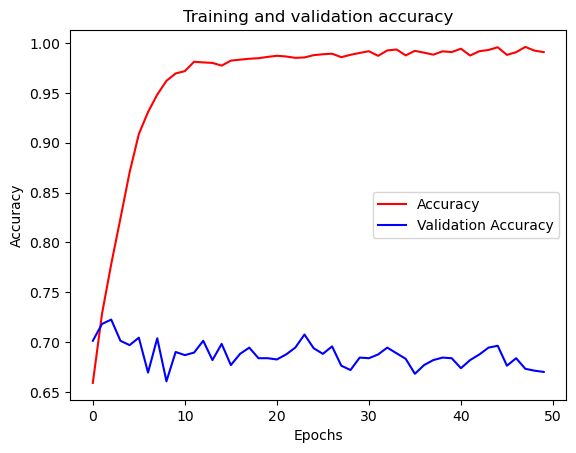

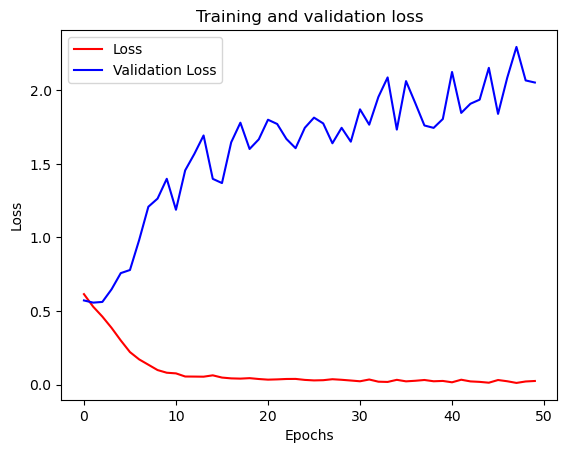

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!